In [26]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import torch
import numpy as np

from sklearn.metrics import mean_squared_error
import random
import os
import matplotlib.pyplot as plt
from numba import jit
import pickle
from scipy.interpolate import interp1d

SystemError: initialization of _internal failed without raising an exception

In [38]:
class testCNN(nn.Module):
    def __init__(self):
        super(testCNN, self).__init__()
        # Probe 1
        self.x1_conv1 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.x1_bn1 = nn.BatchNorm1d(256)
        self.x1_pool1 = nn.MaxPool1d(kernel_size=6, stride=2)
        
        self.x1_conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.x1_bn2 = nn.BatchNorm1d(128)
        self.x1_pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.x1_conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.x1_bn3 = nn.BatchNorm1d(64)
        self.x1_pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        """self.x1_conv4 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.x1_bn4 = nn.BatchNorm1d(1)
        self.x1_pool4 = nn.MaxPool1d(kernel_size=2, stride=2)"""
        
        # Probe 2
        self.x2_conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.x2_bn1 = nn.BatchNorm1d(32)
        self.x2_pool1 = nn.MaxPool1d(kernel_size=6, stride=2)
        
        self.x2_conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.x2_bn2 = nn.BatchNorm1d(64)
        self.x2_pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.x2_conv3 = nn.Conv1d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.x2_bn3 = nn.BatchNorm1d(16)
        self.x2_pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        """self.x2_conv4 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.x2_bn4 = nn.BatchNorm1d(1)
        self.x2_pool4 = nn.MaxPool1d(kernel_size=2, stride=2)"""
        
        self.fc1 = nn.Linear(64, out_features=16)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(16, out_features=6)
        
    def forward(self, x):
        # x1 = probe 1, x2 = probe 2
        batch_size = x.shape[0]
        x1 = self.x1_bn1(torch.relu(self.x1_conv1(x[:, 0].reshape(-1, 128, 1))))
        x = x.reshape(batch_size, 128, -1)
        print(x.shape)
        x1 = self.x1_bn2(torch.relu(self.x1_conv2(x1)))
        
        print(x.shape)
        x1 = self.x1_bn3(torch.relu(self.x1_conv3(x1)))
        print(x.shape)
        
        """x1 = self.x1_pool4(
            self.x1_bn4(torch.relu(self.x1_conv4(x1)))
        )"""
        
        """x2 = self.x2_pool1(
            self.x2_bn1(torch.relu(self.x2_conv1(x[:, 1].reshape(-1, 1, 128))))
        )
        
        x2 = self.x2_pool2(
            self.x2_bn2(torch.relu(self.x2_conv2(x2)))
        )
        
        x2 = self.x2_pool3(
            self.x2_bn3(torch.relu(self.x2_conv3(x2)))
        )
        """
        """ x2 = self.x2_pool4(
            torch.relu(self.x2_conv4(x2))
        )"""
        #x1 = x1.view(batch_size, 6)
        #x2 = x2.view(batch_size, 6)
        
        """x = torch.cat((x1, x2), dim=1)
        x = x.view(batch_size, -1)"""
        x = x.view(batch_size, -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        #x = x.view(-1)
        #print(x.shape)
        return x

# MAE loss

In [6]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# 704 samples produced. Input is the y values of the signal
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        # Probe 1
        self.x1_conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.x1_bn1 = nn.BatchNorm1d(32)
        self.x1_pool1 = nn.MaxPool1d(kernel_size=6, stride=2)
        
        self.x1_conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.x1_bn2 = nn.BatchNorm1d(64)
        self.x1_pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.x1_conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.x1_bn3 = nn.BatchNorm1d(32)
        self.x1_pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        """self.x1_conv4 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.x1_bn4 = nn.BatchNorm1d(1)
        self.x1_pool4 = nn.MaxPool1d(kernel_size=2, stride=2)"""
        
        # Probe 2
        self.x2_conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.x2_bn1 = nn.BatchNorm1d(32)
        self.x2_pool1 = nn.MaxPool1d(kernel_size=6, stride=2)
        
        self.x2_conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.x2_bn2 = nn.BatchNorm1d(64)
        self.x2_pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.x2_conv3 = nn.Conv1d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.x2_bn3 = nn.BatchNorm1d(16)
        self.x2_pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        """self.x2_conv4 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.x2_bn4 = nn.BatchNorm1d(1)
        self.x2_pool4 = nn.MaxPool1d(kernel_size=2, stride=2)"""
        
        self.fc1 = nn.Linear(16*16, out_features=16)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(16, out_features=6)
        
    def forward(self, x):
        # x1 = probe 1, x2 = probe 2
        batch_size = x.shape[0]
        x1 = self.x1_pool1(
            self.x1_bn1(torch.relu(self.x1_conv1(x[:, 0].reshape(-1, 1, 128))))
        )
        
        x1 = self.x1_pool2(
            self.x1_bn2(torch.relu(self.x1_conv2(x1)))
        )
        
        x1 = self.x1_pool3(
            self.x1_bn3(torch.relu(self.x1_conv3(x1)))
        )
        
        """x1 = self.x1_pool4(
            self.x1_bn4(torch.relu(self.x1_conv4(x1)))
        )"""
        
        """x2 = self.x2_pool1(
            self.x2_bn1(torch.relu(self.x2_conv1(x[:, 1].reshape(-1, 1, 128))))
        )
        
        x2 = self.x2_pool2(
            self.x2_bn2(torch.relu(self.x2_conv2(x2)))
        )
        
        x2 = self.x2_pool3(
            self.x2_bn3(torch.relu(self.x2_conv3(x2)))
        )
        """
        """ x2 = self.x2_pool4(
            torch.relu(self.x2_conv4(x2))
        )"""
        #x1 = x1.view(batch_size, 6)
        #x2 = x2.view(batch_size, 6)
        
        """x = torch.cat((x1, x2), dim=1)
        x = x.view(batch_size, -1)"""
        x = x.view(batch_size, -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        #x = x.view(-1)
        #print(x.shape)
        return x
                            
                            
def train(train_loader, net, LR=0.5, epochs=3000, val_loader=None):
    net.to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr=LR)
    criterion = nn.MSELoss()
    all_MSE = nn.MSELoss()
    val_losses = []
    print(f"Using: {DEVICE}")
                            
    parameter_loss = []
    losses = []
    processed = 0
    last_loss = 0
    for epoch in range(epochs):
        loss = 0
        
        net.train()
        with tqdm(train_loader, unit="batch") as it:
            if epoch > 0:
                it.set_postfix(lastLoss=last_loss, valLoss=val_losses[-1])
            for idx, data in enumerate(it):
                it.set_description(f"Epoch {epoch+1}/{epochs}")
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)

                optimizer.zero_grad()
                predicted = net(inp)

                cost = criterion(out, predicted)
                loss += cost.item()
                cost.backward()
                optimizer.step()
                
                for i in range(len(predicted)):
                    current_MSE = []
                    for j in range(6):
                        current_MSE.append(all_MSE(out[i][j], predicted[i][j]).item())
                    parameter_loss.append(current_MSE)
                    processed += 1
        
        if val_loader:
            val_loss = 0
            net.eval()
            for idx, data in enumerate(val_loader):
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)

                predicted = net(inp)
                cost = criterion(out, predicted)
                val_loss += cost.item()
            val_loss /= len(val_loader)  
            val_losses.append(val_loss)
        
        losses.append(loss)
        last_loss = loss/len(it)
    print("Parameters: Skin YM, Adipose YM, Skin PR, Adipose PR, Skin Perm, Adipose Perm")
    print(f"Sampled Ranges: 10e3 - 50e3, 1e3 - 25e3, 0.48 - 0.499, 0.48 - 0.499, 10e - 12-10e10, 10e-12 - 10e10") 
    print(f"Average parameter loss: {np.mean(np.reshape(np.array(parameter_loss), (-1, 6)), axis=0)}")        
    print(f"Average overall loss: {np.sum(losses)/processed}")
    return losses, parameter_loss, val_losses

def test(test_loader, net):
    net.to(DEVICE)
    net.eval()
    criterion = nn.L1Loss()
    crit = nn.L1Loss()
    

    with torch.no_grad():
            loss = 0
            with tqdm(test_loader, unit=" batch") as it:
                for idx, data in enumerate(it):
                    inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)
                    
                    predicted = net(inp)
                    cost = criterion(out, predicted)
                    l_t = cost.item()
                    loss += l_t
                    print(predicted.size(), out.size(), inp.size())
                    for i in range(len(predicted)):
                        print(f"Difference: {abs(predicted[i] - out[i])}\n\n")
                    
                    #print(f"\n\n\nBatch: {idx}")
                   # print(f"loss: {l_t}")
                    #for i, target in enumerate(out):
                   #     errs = []
                   #     print(f"Targer: {target}, \npredicted: {predicted[i]}\n\n")
                   #     for j in range(len(predicted)):
                   #         errs.append(abs(predicted[i]-target[i])**2)
                   #     print(f"MSE: {np.mean(errs[0])}")
            
            print(f"Average Loss: {loss/len(test_loader)}") 
            
torch.backends.cudnn.benchmark = True

C:\Users\rjsou\AppData\Local\Temp\ipykernel_14364\3536505192.py:1: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xe (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:77.)
  DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# MSE loss

In [220]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# 704 samples produced. Input is the y values of the signal
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        # Probe 1
        self.x1_conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.x1_bn1 = nn.BatchNorm1d(32)
        self.x1_pool1 = nn.MaxPool1d(kernel_size=6, stride=2)
        
        self.x1_conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.x1_bn2 = nn.BatchNorm1d(64)
        self.x1_pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.x1_conv3 = nn.Conv1d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.x1_bn3 = nn.BatchNorm1d(16)
        self.x1_pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.x1_conv4 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.x1_bn4 = nn.BatchNorm1d(1)
        self.x1_pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Probe 2
        self.x2_conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.x2_bn1 = nn.BatchNorm1d(32)
        self.x2_pool1 = nn.MaxPool1d(kernel_size=6, stride=2)
        
        self.x2_conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.x2_bn2 = nn.BatchNorm1d(64)
        self.x2_pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.x2_conv3 = nn.Conv1d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.x2_bn3 = nn.BatchNorm1d(16)
        self.x2_pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.x2_conv4 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.x2_bn4 = nn.BatchNorm1d(1)
        self.x2_pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(14, out_features=6)
        
    def forward(self, x):
        # x1 = probe 1, x2 = probe 2
        batch_size = x.shape[0]
        x1 = self.x1_pool1(
            self.x1_bn1(torch.relu(self.x1_conv1(x[:, 0].reshape(-1, 1, 128))))
        )
        
        x1 = self.x1_pool2(
            self.x1_bn2(torch.relu(self.x1_conv2(x1)))
        )
        
        x1 = self.x1_pool3(
            self.x1_bn3(torch.relu(self.x1_conv3(x1)))
        )
        
        x1 = self.x1_pool4(
            self.x1_bn4(torch.relu(self.x1_conv4(x1)))
        )
        
        x2 = self.x2_pool1(
            self.x2_bn1(torch.relu(self.x2_conv1(x[:, 1].reshape(-1, 1, 128))))
        )
        
        x2 = self.x2_pool2(
            self.x2_bn2(torch.relu(self.x2_conv2(x2)))
        )
        
        x2 = self.x2_pool3(
            self.x2_bn3(torch.relu(self.x2_conv3(x2)))
        )
        
        x2 = self.x2_pool4(
            torch.relu(self.x2_conv4(x2))
        )
        #x1 = x1.view(batch_size, 6)
        #x2 = x2.view(batch_size, 6)
        x = torch.cat((x1, x2), dim=2).reshape(batch_size, 14)
        #print(x.shape, x1.shape, x2.shape)
        x = self.fc1(x)
        return x
                            
                            
def train(train_loader, net, LR=0.1, epochs=3000, val_loader=None):
    net.to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr=LR)
    criterion = nn.MSELoss()
    all_MSE = nn.MSELoss()
    val_losses = []
    print(f"Using: {DEVICE}")
                            
    parameter_loss = []
    losses = []
    processed = 0
    last_loss = 0
    for epoch in range(epochs):
        loss = 0
        
        net.train()
        with tqdm(train_loader, unit="batch") as it:
            if epoch > 0:
                it.set_postfix(lastLoss=last_loss, valLoss=val_losses[-1])
            for idx, data in enumerate(it):
                it.set_description(f"Epoch {epoch+1}/{epochs}")
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)

                optimizer.zero_grad()
                predicted = net(inp)

                cost = criterion(out, predicted)
                loss += cost.item()
                cost.backward()
                optimizer.step()
                
                """for i in range(len(predicted)):
                    current_MSE = []
                    for j in range(6):
                        current_MSE.append(all_MSE(out[i][j], predicted[i][j]).item())
                    parameter_loss.append(current_MSE)
                    processed += 1"""
        
        if val_loader:
            val_loss = 0
            net.eval()
            for idx, data in enumerate(val_loader):
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)

                predicted = net(inp)
                cost = criterion(out, predicted)
                val_loss += cost.item()
            val_loss /= len(val_loader)  
            val_losses.append(val_loss)
        
        losses.append(loss)
        last_loss = loss/len(it)
    print("Parameters: Skin YM, Adipose YM, Skin PR, Adipose PR, Skin Perm, Adipose Perm")
    print(f"Sampled Ranges: 10e3 - 50e3, 1e3 - 25e3, 0.48 - 0.499, 0.48 - 0.499, 10e - 12-10e10, 10e-12 - 10e10") 
    print(f"Average parameter loss: {np.mean(np.reshape(np.array(parameter_loss), (-1, 6)), axis=0)}")        
    print(f"Average overall loss: {np.sum(losses)/processed}")
    return losses, parameter_loss, val_losses

def test(test_loader, net):
    net.to(DEVICE)
    net.eval()
    criterion = nn.MSELoss()

    with torch.no_grad():
            loss = 0
            with tqdm(test_loader, unit=" batch") as it:
                for idx, data in enumerate(it):
                    inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)
                    
                    predicted = net(inp)
                    cost = criterion(out, predicted)
                    l_t = cost.item()
                    loss += l_t
                    print(predicted.size(), out.size(), inp.size())
                    for i in range(len(predicted)):
                        print(f"Difference: {abs(predicted[i] - out[i])}\n\n")
                    
                    #print(f"\n\n\nBatch: {idx}")
                   # print(f"loss: {l_t}")
                    #for i, target in enumerate(out):
                   #     errs = []
                   #     print(f"Targer: {target}, \npredicted: {predicted[i]}\n\n")
                   #     for j in range(len(predicted)):
                   #         errs.append(abs(predicted[i]-target[i])**2)
                   #     print(f"MSE: {np.mean(errs[0])}")
            
            print(f"Average Loss: {loss/len(test_loader)}") 
            
torch.backends.cudnn.benchmark = True

In [3]:
def checkSubsets(signalFolder, sampleFile, splits=4):
    with open(f"{sampleFile}", "rb") as f:
        samples = pickle.load(f).astype(np.float32)
        
    runs = 0
    exps = os.listdir(f"{signalFolder}/")
    exps = [int(exp) for exp in exps]
    
    split_step = len(exps)//splits
    
    fig = plt.figure(constrained_layout=True, figsize=(15, 10*splits))
    intervals = fig.subfigures(nrows=splits, ncols=1)
    
    for i in range(splits):
        lower_idx = i*split_step
        upper_idx = ((i+1)*split_step)-1 if i != splits-1 else len(exps)-1
        mid_idx = (lower_idx + upper_idx) // 2
        
        intervals[i].suptitle(f"Curves in interval [{lower_idx}, {upper_idx}]")
        probes = intervals[i].subfigures(nrows=2, ncols=1)
        
        
        for probe, file in enumerate(['Disp1.csv', 'Disp2.csv']):
            probes[probe].suptitle(f"Probe {probe}")
            curves = probes[probe].subplots(nrows=1, ncols=3)
            
            for curve, idx in enumerate([lower_idx, mid_idx, upper_idx]):
                a = pd.read_csv(f"{signalFolder}/{idx}/{file}")
                a.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)
                
                title = "First" if curve == 0 else "Midpoint" if curve == 1 else "Last"
                curves[curve].set_title(title)
                a.plot(ax=curves[curve], x='x', y='y')
                print(a['x'].values[0], a['x'].values[0])

0.005 0.005
0.005 0.005
0.005 0.005
0.005 0.005
0.005 0.005
0.005 0.005
0.005 0.005
0.005 0.005
0.005 0.005
0.005 0.005
0.005 0.005
0.005 0.005


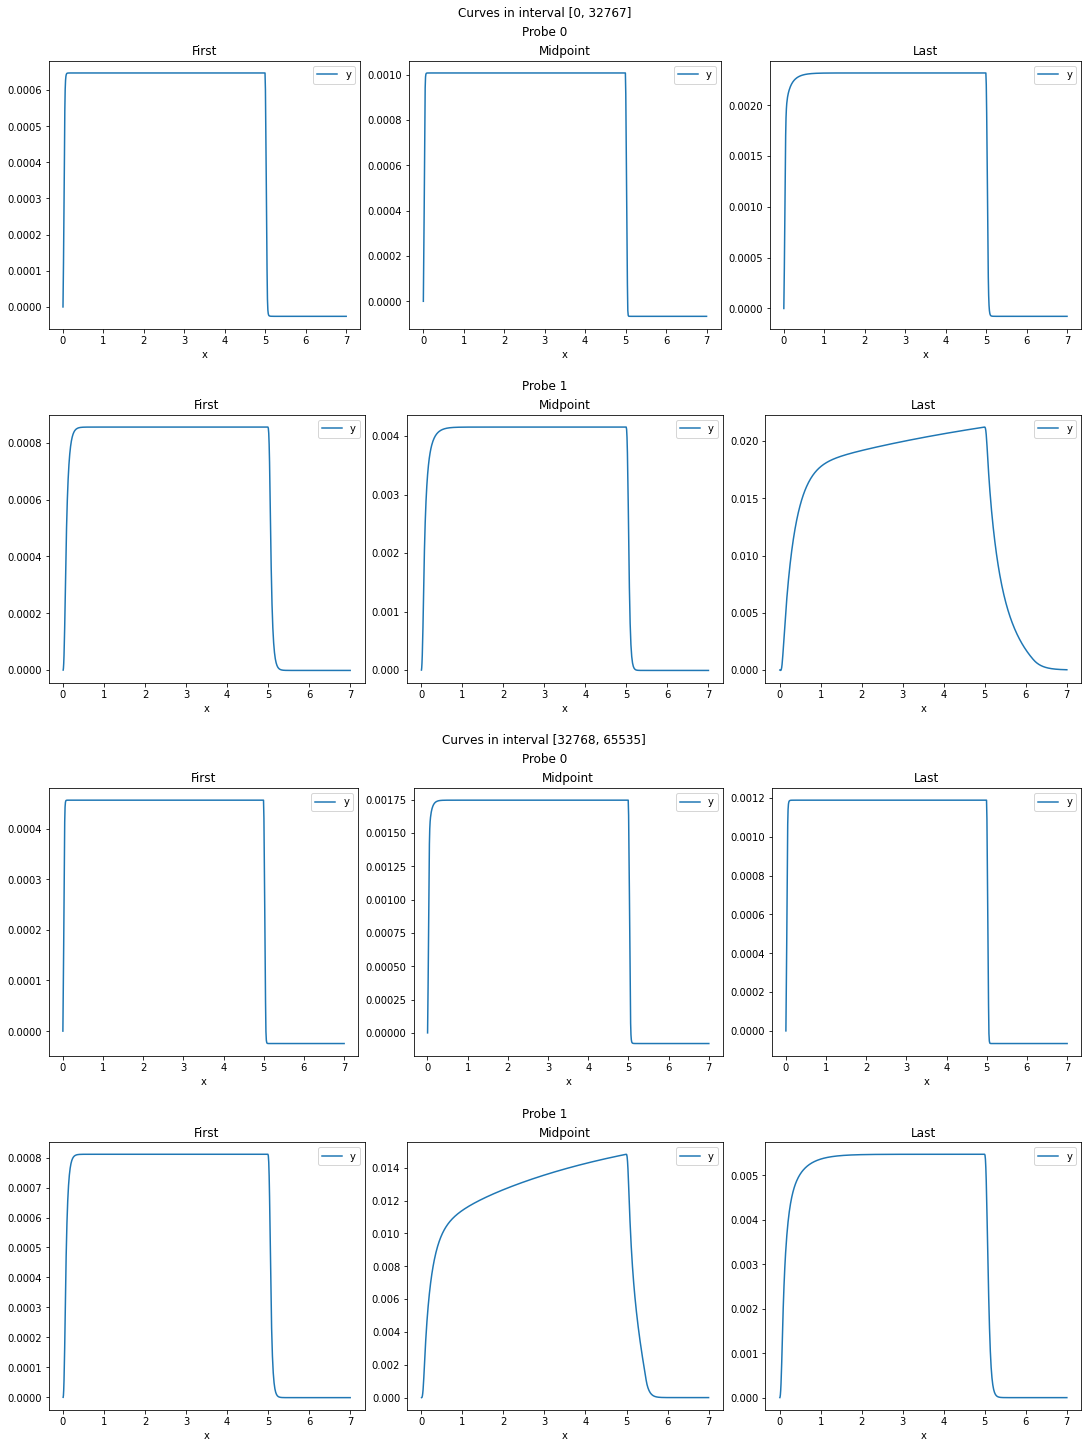

In [35]:
checkSubsets("D:/SamplingResults", "C:/Users/rjsou/Documents/MastersDiss/Sampling/Samples.pkl", splits=2)

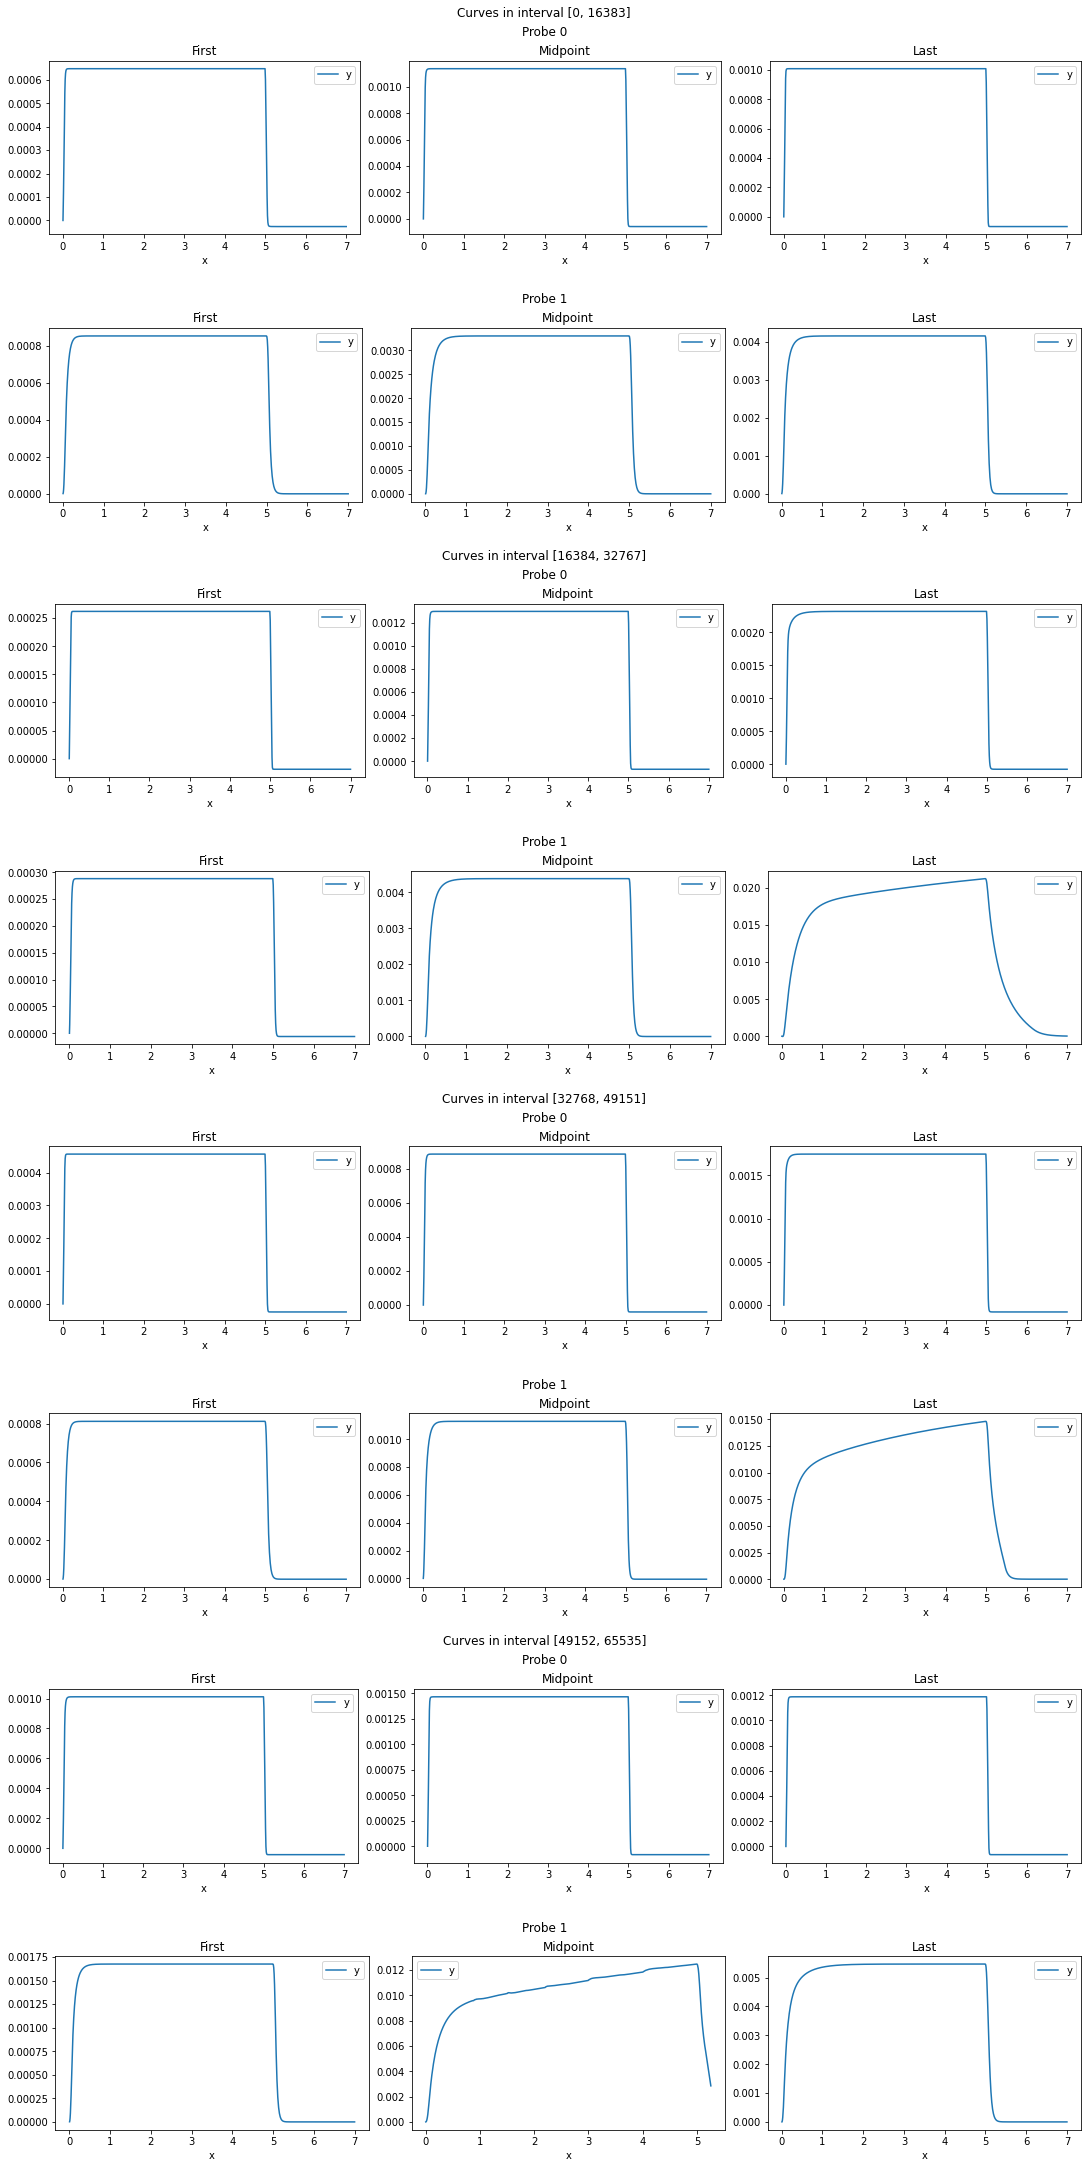

In [99]:
checkSubsets("D:/SamplingResults", "C:/Users/rjsou/Documents/MastersDiss/Sampling/Samples.pkl")

In [339]:
def showInvalids(signalFolder):
    probe1_missing = []
    probe2_missing = []
    both_missing = []
    incomplete_1 = []
    incomplete_2 = []
    
    for run in os.listdir(f"{signalFolder}/"):  
        inp = []
        fail = False

        files = os.listdir(f"{signalFolder}/{run}/")

        if 'Disp1.csv' not in files:
            if 'Disp2.csv' not in files:
                both_missing.append(run)
            else:
                probe1_missing.append(run)
            continue
        elif 'Disp2.csv' not in files:
            probe2_missing.append(run)
            continue

        for file in ['Disp1.csv', 'Disp2.csv']:
            a = pd.read_csv(f"{signalFolder}/{run}/{file}")
            a.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)
            #a = pd.concat([pd.DataFrame([[0,0.1]], columns=a.columns), a], ignore_index=True)
            if a['x'].max() != 7.0:
                if file == 'Disp1.csv':
                    incomplete_1.append(run)
                else:
                    incomplete_2.append(run)
                    
    print("Exps with both missing:", len(both_missing))
    print("Exps with probe1 missing:", len(probe1_missing))
    print("Exps with probe2 missing:", len(probe2_missing))
    print("Exps with incomplete probe1:", len(incomplete_1))
    print("Exps with incomplete probe2:", len(incomplete_2))
    
    #with open(f"missingSamples.pkl", "wb") as f:
       #     pickle.dump(list(
       #         set(probe1_missing+probe2_missing+both_missing+incomplete_1+incomplete_2)
      #      ), f)
            
   # print(list(
    #            set(probe1_missing+probe2_missing+both_missing+incomplete_1+incomplete_2
    #               )
     #       ))
    

In [138]:
with open("missingSamples.pkl", "rb") as f:
            a = pickle.load(f)

In [6]:
with open("statsRes.pkl", "rb") as f:
            a = pickle.load(f)

In [5]:
def getStats(signalFolder, sampleFile):
    me = []
    mse = []
    sse = []
    pts = range(1, 500, 50)

    with open(f"{sampleFile}", "rb") as f:
        samples = pickle.load(f).astype(np.float32)
    print(len(pts))
    for steps in pts:
        x_interped = []
        x_origin = []

        runs = 0
        exps = os.listdir(f"{signalFolder}/")
        exps = [int(exp) for exp in exps]
        random.shuffle(exps)
        exps = exps[:19999]
        print()

        for run in tqdm(exps[:19999]):
            inp = []
            fail = False

            files = os.listdir(f"{signalFolder}/{run}/")

            if files != ['Disp1.csv', 'Disp2.csv']:
                continue



            for file in files:
                a = pd.read_csv(f"{signalFolder}/{run}/{file}")
                a.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)
                if a['x'].max() != 7.0:
                    failed = True
                    break
                #a = pd.concat([pd.DataFrame([[0,0.1]], columns=a.columns), a], ignore_index=True)


                # Interpolate curve for consistent x values
                xNew = np.linspace(0, 7, num=steps, endpoint=False)
                interped = interp1d(a['x'], a['y'], kind='cubic', fill_value="extrapolate")(xNew)

                # Find closest value in original to interpreted
                orig = np.array(a['y'].values)
                closest = []
                for y in interped:

                    diff = []
                    for y_2 in orig:
                        # Get difference
                        diff.append(abs(y_2 - y))

                    # Find location of smallest difference
                    idx = np.array(diff).argmin()
                    # Use as representative point
                    closest.append(orig[idx])


                #fix, ax = plt.subplots(1, 2)
                #ax[0].plot(xNew, interped)
                #a.plot(ax=ax[1], x='x', y='y')
                #if run == 3:
                   # break


                #if len(a) < 702:
                #    print(f"{signalFolder}/{run}/{file}: {len(a)}")
               #     fail = True
                 #   break

               # while len(a) > 702:
                #    a = a.drop(index=np.random.randint(0, len(a)-1)).reset_index(drop=True)

                #print(a)

                x_interped.append(interped.astype(np.float32))
                x_origin.append(closest)
                #print(closest, "\n\n", x_origin)




            if not fail:
                #print(x_origin, "\n", x_interped, "\n", steps)
                mse.append(mean_squared_error(x_origin, x_interped))
                sse.append(mse[-1]*len(x_origin))
                me.append(np.max(np.absolute(np.array(x_origin) - np.array(x_interped))))

    return me, mse, pts, sse


In [340]:
showInvalids("D:/SamplingResults")

Exps with both missing: 61
Exps with probe1 missing: 0
Exps with probe2 missing: 52
Exps with incomplete probe1: 6
Exps with incomplete probe2: 799


In [341]:
stats = []
with open(f"statsRes.pkl", "rb") as f:
    stats = pickle.load(f) 

In [38]:
stats

[[2.617318897435616e-11,
  24710.833214317467,
  26001.69611563166,
  26447.173252396628,
  26672.830389218187,
  26809.16783071286,
  26900.45455632038,
  26965.85360834978,
  27015.009344242335,
  27053.304739832198],
 [3.4176950162714275e-06,
  3226740601.1255746,
  3395301478.7791824,
  3453471883.2979517,
  3482938192.2241106,
  3500741135.3344855,
  3512661355.964315,
  3521201164.178314,
  3527619920.171164,
  3532620532.9272885],
 [0.0001773903836016855,
  83135.5859375,
  87178.8046875,
  88573.4375,
  89279.8046875,
  89706.5546875,
  89992.28125,
  90196.984375,
  90350.8359375,
  90470.6953125],
 451]

In [ ]:
stats = getStats("D:/SamplingResults", "C:/Users/rjsou/Documents/MastersDiss/Sampling/Samples.pkl")

10



100%|████████████████████████████████████████████████████████████████████████████| 19999/19999 [09:41<00:00, 34.41it/s]


100%|████████████████████████████████████████████████████████████████████████████| 19999/19999 [54:54<00:00,  6.07it/s]


100%|██████████████████████████████████████████████████████████████████████████| 19999/19999 [1:41:13<00:00,  3.29it/s]


 41%|███████████████████████████████                                            | 8269/19999 [35:21<1:32:43,  2.11it/s]

In [298]:
print(stats)

               Skin                                 Adipose              \
                 YM          PR          Perm            YM          PR   
count    442.000000  442.000000  4.420000e+02    442.000000  442.000000   
mean   11541.416639    0.482367  2.099148e-10  13921.409878    0.489876   
std     1634.706887    0.002086  2.112935e-10   6445.319584    0.005532   
min    10002.064891    0.480017  1.010693e-11   1184.834242    0.480021   
25%    10414.485568    0.480862  4.216558e-11   8624.880254    0.485198   
50%    11043.898612    0.481853  1.241871e-10  13935.550213    0.489933   
75%    12072.557770    0.483244  3.206703e-10  19294.803381    0.494773   
max    20525.368452    0.496329  8.954088e-10  24983.963966    0.498976   

                     
               Perm  
count  4.420000e+02  
mean   5.138400e-10  
std    2.860695e-10  
min    1.252475e-11  
25%    2.689954e-10  
50%    5.161871e-10  
75%    7.557144e-10  
max    9.997882e-10  


KeyError: 0

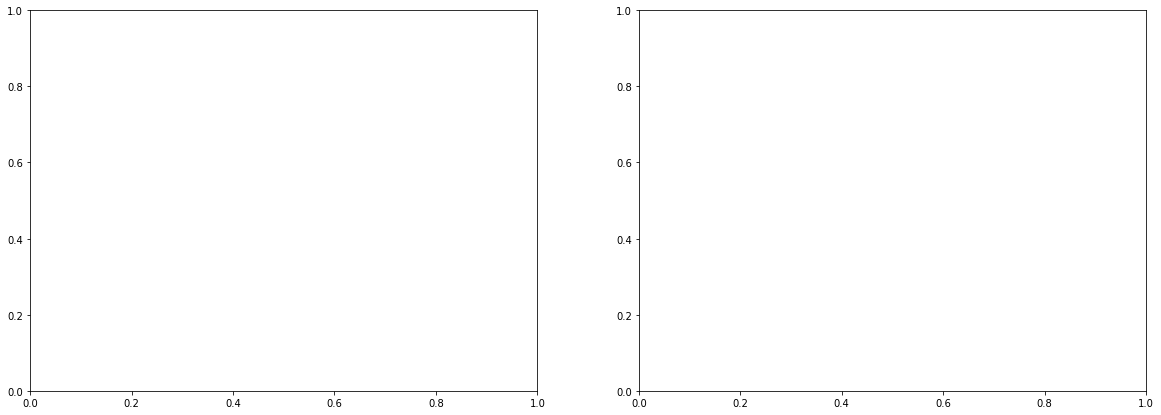

In [299]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].plot(range(1, 500, 50), stats[0])
ax[1].plot(range(1, 500, 50), stats[1])
ax[1].set(ylabel="SSE", xlabel="Num. Steps")
ax[0].set(ylabel="ME", xlabel="Num. Steps")
plt.show()
# Check max loss
# Test subsets to restrict

# Learning

In [9]:
with open("filtered.pkl", "rb") as f:
    runs = pickle.load(f)

In [10]:
from torch.utils.data import Dataset
from torch import tensor

# Folder name will correspond to index of sample
class Data(Dataset):
    def __init__(self, signalFolder, sampleFile, runs, steps=128):
        # Load both disp1 and disp2 from each folder
        # Folders ordered according to index of sample
        # Use the corresponding sample as y -> append probe?
        self.input = []
        self.output = []
        
        with open(f"{sampleFile}", "rb") as f:
             samples = pickle.load(f)

        self.min = [min(np.array(samples[runs])[:, i]) for i in range(6)]
        self.max = [max(np.array(samples[runs])[:, i]) for i in range(6)]
        
        for run in runs: #os.listdir(f"{signalFolder}/"):  
            inp = []
            fail = False
            
            files = os.listdir(f"{signalFolder}/{run}/")
            
            if files != ['Disp1.csv', 'Disp2.csv']:
                continue
            
            for file in files:
                a = pd.read_csv(f"{signalFolder}/{run}/{file}")
                a.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)
                
                if a['x'].max() != 7.0:
                    fail = True
                    break
                #a = pd.concat([pd.DataFrame([[0,0.1]], columns=a.columns), a], ignore_index=True)
                

                # Interpolate curve for consistent x values
                xNew = np.linspace(0, 7, num=steps, endpoint=False)
                interped = interp1d(a['x'], a['y'], kind='cubic', fill_value="extrapolate")(xNew)
                    
                #fix, ax = plt.subplots(1, 2)
                #ax[0].plot(xNew, interped)
                #a.plot(ax=ax[1], x='x', y='y')
                #if run == 3:
                   # break
                
                
                #if len(a) < 702:
                #    print(f"{signalFolder}/{run}/{file}: {len(a)}")
               #     fail = True
                 #   break
                
               # while len(a) > 702:
                #    a = a.drop(index=np.random.randint(0, len(a)-1)).reset_index(drop=True)
                
                #print(a)
                
                inp.append(list(interped))
            
            if not fail:
                if len(inp) != 2:
                    raise Exception("sdf")
                #print(inp[0])
                #raise Exception("sdf")

                self.input.append(inp)
                self.output.append(samples[int(run)])
        
        self.output = tensor(self.output)
        self.input = tensor(self.input)
        #for dim in range(6):
       #     self.output[:, dim] = (self.output[:, dim] - self.min[dim])/(self.max[dim] - self.min[dim])
        #print(self.output)
        
    def __len__(self):
        return len(self.output)
    
    def __getitem__(self, idx):
        sample = {"input": self.input[idx], "output": self.output[idx]}
        return sample

In [11]:
dataset = Data("D:/SamplingResults", "C:/Users/rjsou/Documents/MastersDiss/Sampling/Samples.pkl", runs)

In [12]:
len(dataset)

442

In [13]:
from torch.utils.data import DataLoader
train_n = int(0.8 * len(dataset))
test_n = len(dataset) - train_n
train_set, test_set = torch.utils.data.random_split(dataset, [train_n, test_n])
train_loader, test_loader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True), DataLoader(test_set, batch_size=32, shuffle=True, pin_memory=True)

In [14]:
DEVICE

device(type='cuda', index=0)

In [39]:
net = testCNN() #3.01e7 - without batchnorm, 0.5 lr -> 8.69e+6

In [40]:
loss, p_loss, v_loss = train(train_loader, net, val_loader=test_loader)

Using: cuda:0


Epoch 1/3000:   0%|                                                                          | 0/12 [00:00<?, ?batch/s]

torch.Size([32, 128, 2])
torch.Size([32, 128, 2])
torch.Size([32, 128, 2])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x256 and 64x16)

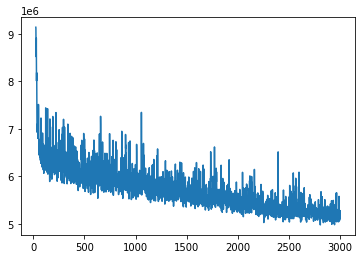

In [38]:
plt.plot(range(25, len(v_loss)), v_loss[25:], label="Validation loss")

In [189]:
ts = []
for t in v_loss:
    if t < 0.25e7:
        ts.append(t)

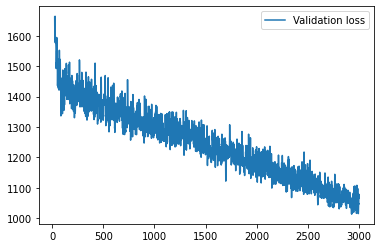

In [31]:
# MAE
plt.plot(range(25, len(v_loss)), v_loss[25:], label="Validation loss")
#plt.plot(range(50, len(loss)), loss[50:], label="Training Loss")
plt.legend()

In [32]:
test(test_loader, net)

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.50 batch/s]

torch.Size([32, 6]) torch.Size([32, 6]) torch.Size([32, 2, 128])
Difference: tensor([4.5873e+03, 3.1554e+03, 4.8033e-01, 4.8312e-01, 2.8447e-10, 9.9794e-10],
       device='cuda:0')


Difference: tensor([2.1217e+02, 7.4317e+03, 4.8661e-01, 4.9513e-01, 2.1106e-11, 7.3025e-10],
       device='cuda:0')


Difference: tensor([1.0157e+03, 6.1985e+03, 4.8024e-01, 4.9605e-01, 3.4752e-10, 5.3534e-10],
       device='cuda:0')


Difference: tensor([6.4204e+02, 7.1198e+03, 4.8081e-01, 4.8002e-01, 4.4200e-11, 7.7854e-11],
       device='cuda:0')


Difference: tensor([1.7380e+03, 5.4446e+03, 4.8390e-01, 4.8870e-01, 2.4331e-11, 7.0956e-10],
       device='cuda:0')


Difference: tensor([2.0232e+03, 1.6203e+03, 4.8079e-01, 4.8443e-01, 2.4877e-10, 7.9124e-10],
       device='cuda:0')


Difference: tensor([3.2247e+03, 1.1688e+02, 4.8248e-01, 4.8577e-01, 3.7612e-10, 7.6961e-10],
       device='cuda:0')


Difference: tensor([1.0741e+03, 5.2402e+03, 4.8045e-01, 4.9377e-01, 3.5836e-10, 3.9791e-10],
       de

# Filtering

In [53]:
from scipy.interpolate import interp1d
import pickle
#from numba import cuda, jit

def filterData():
    signalFolder, sampleFile, steps = "D:/SamplingResults", "../Data/Samples.pkl", 128
    filtered = []
    samples = []
    runs = []
    
    f = open(f"{sampleFile}", "rb")
    samples = pickle.load(f).astype(np.float32)
    f.close()

    for i, run in enumerate(tqdm(os.listdir(f"{signalFolder}/"))):  
        inp = []
        fail = False

        #if i == 2000:
           # break
            
        files = os.listdir(f"{signalFolder}/{run}/")

        if files != ['Disp1.csv', 'Disp2.csv']:
            continue

        for file in files:
            a = pd.read_csv(f"{signalFolder}/{run}/{file}")
            a.rename(columns = {'0':'x', '0.1': 'y'}, inplace=True)

            if a['x'].max() != 7.0:
                fail = True
                break
            
            # Interpolate curve for consistent x values
            xNew = np.linspace(0, 7, num=steps, endpoint=True)
            interped = interp1d(a['x'], a['y'], kind='cubic', fill_value="extrapolate")(xNew)
            interped[0] = 0.0
            
            # Check no sudden increases/decreases in gradient
            max_def = 0 # x when displacement is first highest
            max_def_final = 0
            min_def = 0 # x when skin fully rebounds
            step_second = 1/(7/steps) # Number of steps in each second
            
            der = 0
            for i in range(len(interped)):
                # Check x where max displacement occurs
                if interped[i] > max(interped)*0.99 and max_def == 0:
                    max_def = i/step_second
                
                if max_def != 0 and interped[i] == max(interped):
                    max_def_final = i/step_second
                
                if max_def != 0 and interped[i] == min(interped[int(max_def_final):]):
                    min_def = i/step_second
   
            #if np.all(np.diff(der) < 0):
            # Cannot be within 10% of the max before 1
            # Cannot reach rebound completely before 5.2 seconds
            if min_def-max_def_final < 0.5 or max_def < 1:
                fail = True
                break
                    
            
            # Position where x=1
            #x1_idx = int(1//(7/steps))
            # Displacement cant peak at x=1
           # if  interped[x1_idx] > m*0.98 :
             #   fail = True
             #   break
            
            #fix, ax = plt.subplots(1, 2)
            #ax[0].plot(xNew, interped)
            #a.plot(ax=ax[1], x='x', y='y')

            a = interped.astype(np.float32)
            inp.append(a)

        if not fail:
            filtered.append(inp)
            runs.append(run)
    return filtered, runs

In [54]:
filtered, runs = filterData()

100%|████████████████████████████████████████████████████████████████████████████| 65536/65536 [12:32<00:00, 87.07it/s]


In [55]:
runs = [int(run) for run in runs]

In [56]:
len(runs)

442

In [39]:
getStat(runs)

[[10073.931626975536, 49995.198249816895], [1008.155345916748, 24996.7999458313], [0.480031236202456, 0.4989983624219894], [0.4800064818849787, 0.49899956059455874], [1.0311538660898805e-11, 9.99462018609047e-10], [1.005156890489161e-11, 9.999791699647904e-10]]


Skin                                  Adipose               \
                 YM           PR          Perm            YM           PR   
count   2241.000000  2241.000000  2.241000e+03   2241.000000  2241.000000   
mean   41234.410555     0.486886  2.942307e-10  13446.499660     0.489572   
std     7230.080542     0.002535  2.455953e-10   7178.062773     0.005429   
min    10073.931627     0.480031  1.031154e-11   1008.155346     0.480006   
25%    40556.595325     0.485309  1.410659e-10   6721.218705     0.484752   
50%    42249.553204     0.487315  1.924621e-10  14362.639427     0.489849   
75%    44752.135277     0.488571  3.643774e-10  19631.258965     0.494145   
max    49995.198250     0.498998  9.994620e-10  24996.799946     0.499000   

                     
               Perm  
count  2.241000e+03  
mean   5.034419e-10  
std    2.920893e-10  
min    1.005157e-11  
25%    2.414258e-10  
50%    5.123215e-10  
75%    7.617487e-10  
max    9.999792e-10

In [47]:
getStat(runs)

[[10002.63212971715, 20191.714965135132], [1201.874171702788, 24974.445571872508], [0.48001743594912955, 0.4963196052489023], [0.480045802331725, 0.49896691378164393], [1.0122554437254461e-11, 8.932904181909943e-10], [1.2940936741104208e-11, 9.997167208723091e-10]]


Skin                                  Adipose               \
                 YM           PR          Perm            YM           PR   
count   2241.000000  2241.000000  2.241000e+03   2241.000000  2241.000000   
mean   11547.151078     0.482472  2.119222e-10  14249.873901     0.489839   
std     1672.202185     0.002104  2.140957e-10   6410.340481     0.005467   
min    10002.632130     0.480017  1.012255e-11   1201.874172     0.480046   
25%    10424.724594     0.480889  4.105417e-11   9056.635859     0.485150   
50%    10983.994801     0.481965  1.267611e-10  14519.267995     0.489904   
75%    12010.897816     0.483447  3.280167e-10  19708.116492     0.494668   
max    20191.714965     0.496320  8.932904e-10  24974.445572     0.498967   

                     
               Perm  
count  2.241000e+03  
mean   5.135171e-10  
std    2.766559e-10  
min    1.294094e-11  
25%    2.817015e-10  
50%    5.122555e-10  
75%    7.474656e-10  
max    9.997167e-10

In [52]:
getStat(runs)

[[10073.931626975536, 49995.198249816895], [1008.155345916748, 24996.7999458313], [0.480031236202456, 0.4989983624219894], [0.4800064818849787, 0.49899956059455874], [1.0311538660898805e-11, 9.99462018609047e-10], [1.005156890489161e-11, 9.999791699647904e-10]]


Skin                                  Adipose               \
                 YM           PR          Perm            YM           PR   
count   2241.000000  2241.000000  2.241000e+03   2241.000000  2241.000000   
mean   41234.410555     0.486886  2.942307e-10  13446.499660     0.489572   
std     7230.080542     0.002535  2.455953e-10   7178.062773     0.005429   
min    10073.931627     0.480031  1.031154e-11   1008.155346     0.480006   
25%    40556.595325     0.485309  1.410659e-10   6721.218705     0.484752   
50%    42249.553204     0.487315  1.924621e-10  14362.639427     0.489849   
75%    44752.135277     0.488571  3.643774e-10  19631.258965     0.494145   
max    49995.198250     0.498998  9.994620e-10  24996.799946     0.499000   

                     
               Perm  
count  2.241000e+03  
mean   5.034419e-10  
std    2.920893e-10  
min    1.005157e-11  
25%    2.414258e-10  
50%    5.123215e-10  
75%    7.617487e-10  
max    9.999792e-10

In [ ]:
from scipy.interpolate import interp1d
import pickle
#from numba import cuda, jit

def filterData():
    signalFolder, sampleFile, steps = "D:/SamplingResults2", "C:/Users/rjsou/Documents/MastersDiss/newSamples.pkl", 128
    filtered = []
    samples = []
    runs = []
    
    f = open(f"{sampleFile}", "rb")
    samples = pickle.load(f).astype(np.float32)
    f.close()

    for i, run in enumerate(tqdm(os.listdir(f"{signalFolder}/"))):  
        inp = []
        fail = False

        #if i == 2000:
           # break
            
        files = os.listdir(f"{signalFolder}/{run}/")

        if files != ['Disp1.csv', 'Disp2.csv']:
            continue

        for file in files:
            a = pd.read_csv(f"{signalFolder}/{run}/{file}")
            a.rename(columns = {'0':'x', '0.1': 'y'}, inplace=True)

            if a['x'].max() != 7.0:
                fail = True
                break
            
            # Interpolate curve for consistent x values
            xNew = np.linspace(0, 7, num=steps, endpoint=True)
            interped = interp1d(a['x'], a['y'], kind='cubic', fill_value="extrapolate")(xNew)
            interped[0] = 0.0
            
            # Check no sudden increases/decreases in gradient
            max_def = 0 # x when displacement is first highest
            max_def_final = 0
            min_def = 0 # x when skin fully rebounds
            step_second = 1/(7/steps) # Number of steps in each second
            
            der = 0
            for i in range(len(interped)):
                # Check x where max displacement occurs
                if interped[i] > max(interped)*0.99 and max_def == 0:
                    max_def = i/step_second
                
                if max_def != 0 and interped[i] == max(interped):
                    max_def_final = i/step_second
                
                if max_def != 0 and interped[i] == min(interped[int(max_def_final):]):
                    min_def = i/step_second
   
            #if np.all(np.diff(der) < 0):
            # Cannot be within 10% of the max before 1
            # Cannot reach rebound completely before 5.2 seconds
            if min_def-max_def_final < 0.5 or max_def < 1:
                fail = True
                break
                    
            
            # Position where x=1
            #x1_idx = int(1//(7/steps))
            # Displacement cant peak at x=1
           # if  interped[x1_idx] > m*0.98 :
             #   fail = True
             #   break
            
            #fix, ax = plt.subplots(1, 2)
            #ax[0].plot(xNew, interped)
            #a.plot(ax=ax[1], x='x', y='y')

            a = interped.astype(np.float32)
            inp.append(a)

        if not fail:
            filtered.append(inp)
            runs.append(run)
    return filtered, runs

In [159]:
with open(f"filtered.pkl", "rb") as f:
    filtered = pickle.load(f)
with open(f"newSamples.pkl", "rb") as f:
    samples = pickle.load(f)
    
with open(f"D:/SamplingResults2/{filtered[3]}/Disp1.csv", "rb") as f:
    c = pd.read_csv(f)
c.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)

In [28]:
display(c)

x         y
0    0.005000  0.000000
1    0.011000  0.000066
2    0.017800  0.000150
3    0.025240  0.000251
4    0.033192  0.000367
..        ...       ...
699  6.966941 -0.000039
700  6.976941 -0.000039
701  6.986941 -0.000039
702  6.996941 -0.000039
703  7.000000 -0.000039

[704 rows x 2 columns]

In [9]:
len(os.listdir("D:/SamplingResults2"))

65536

In [6]:
curves, runs = filterData()

 23%|█████████████████▎                                                          | 14962/65536 [02:53<09:46, 86.20it/s]


KeyboardInterrupt: 

In [155]:
with open("filtered.pkl", "wb") as f:
    pickle.dump(runs, f)

In [153]:
len(runs)

2241

In [154]:
runs = [int(run) for run in runs]

In [237]:
closest = []
for y in inflection_points:
    diff = []
    for y_2 in curves[0][0]:
        # Get difference
        diff.append(abs(y_2 - y))

    # Find location of smallest difference
    idx = np.array(diff).argmin()
    # Use as representative point
    closest.append(curves[0][0][idx])
print(closest)

[0.0035866718, 0.0035866718, 0.0035866718, 0.0035866718, 0.0035866718, 0.0035866718, 0.0035866718, 0.0035866718]


In [50]:
def getStat(runs):
    with open(f"../Data/Samples.pkl", "rb") as f:
        samples = pickle.load(f)
    
    samples = np.array(samples[runs])
    
    df = pd.DataFrame({
        ("Skin", "YM"): samples[:, 0],
        ("Skin", "PR"): samples[:, 2],
        ("Skin", "Perm"): samples[:, 4],
        ("Adipose", "YM"): samples[:, 1],
        ("Adipose", "PR"): samples[:, 3],
        ("Adipose", "Perm"): samples[:, 5]
    })
    
    ranges = [
        [min(samples[:, 0]), max(samples[:, 0])], # Skin YM
        [min(samples[:, 1]), max(samples[:, 1])], # Adipose YM
        [min(samples[:, 2]), max(samples[:, 2])], # Skin PR
        [min(samples[:, 3]), max(samples[:, 3])], # Adipose PR
        [min(samples[:, 4]), max(samples[:, 4])], # Skin Perm
        [min(samples[:, 5]), max(samples[:, 5])],
    ]
    
    """with open("sampleRanges.pkl", "wb") as f:
        pickle.dump(ranges, f)"""
    
    print(ranges)
    
    return df.describe()

In [30]:
getStat()

[[10002.070918522486, 20525.35277112788], [1184.9401003155524, 24983.860413046485], [0.4800166913281132, 0.49632834205447174], [0.4800216373464481, 0.49897538130241026], [1.0110477137669555e-11, 8.954037807180309e-10], [1.2535300078830969e-11, 9.997863939304647e-10]]


Skin                                   Adipose                \
                 YM            PR          Perm            YM            PR   
count  65536.000000  65536.000000  6.553600e+04  65536.000000  65536.000000   
mean   15263.716667      0.488173  4.527579e-10  13084.399093      0.489498   
std     3037.839249      0.004709  2.555666e-10   6870.269393      0.005472   
min    10002.070919      0.480017  1.011048e-11   1184.940100      0.480022   
25%    12632.948683      0.484095  2.314326e-10   7134.598675      0.484760   
50%    15263.721376      0.488173  4.527580e-10  13084.401587      0.489498   
75%    17894.479368      0.492251  6.740828e-10  19034.203877      0.494237   
max    20525.352771      0.496328  8.954038e-10  24983.860413      0.498975   

                     
               Perm  
count  6.553600e+04  
mean   5.061565e-10  
std    2.850006e-10  
min    1.253530e-11  
25%    2.593428e-10  
50%    5.061611e-10  
75%    7.529642e-10  
max    9.997864e-10

In [28]:
getStat()

[[10000.021941959858, 49999.76873397827], [1000.1313388347626, 24999.982833862305], [0.48000001420918853, 0.4989998255968094], [0.4800000890418887, 0.4989997950196266], [1.0003745201975107e-11, 9.999986428022385e-10], [1.0010538566857576e-11, 9.99996931552887e-10]]


Skin                                   Adipose                \
                 YM            PR          Perm            YM            PR   
count  65536.000000  65536.000000  6.553600e+04  65536.000000  65536.000000   
mean   29999.999981      0.489500  5.050000e-10  12999.999989      0.489500   
std    11547.093481      0.005485  2.857906e-10   6928.256089      0.005485   
min    10000.021942      0.480000  1.000375e-11   1000.131339      0.480000   
25%    19999.988228      0.484750  2.575085e-10   7000.193477      0.484750   
50%    29999.971390      0.489500  5.049988e-10  12999.942780      0.489500   
75%    39999.797344      0.494250  7.524903e-10  18999.840856      0.494250   
max    49999.768734      0.499000  9.999986e-10  24999.982834      0.499000   

                     
               Perm  
count  6.553600e+04  
mean   5.050000e-10  
std    2.857906e-10  
min    1.001054e-11  
25%    2.575103e-10  
50%    5.050037e-10  
75%    7.524970e-10  
max    9.999969e-10

In [59]:
a = curves

In [6]:
with open("../data/sampleRanges.pkl", "rb") as f:
    a = pickle.load(f)

In [7]:
a

[[10002.064891159534, 20525.368452072144],
 [1184.8342418670654, 24983.96396636963],
 [0.48001662007905543, 0.4963285802602768],
 [0.48002141393721104, 0.49897557336091997],
 [1.0106930956244467e-11, 8.954087936878205e-10],
 [1.2524750186130404e-11, 9.997882181406023e-10]]

In [9]:
with open("../data/Samples.pkl", "rb") as f:
    old = pickle.load(f)

In [21]:
np.all(np.array(old)[:, 0] < 20525.368452072144)

False

[]

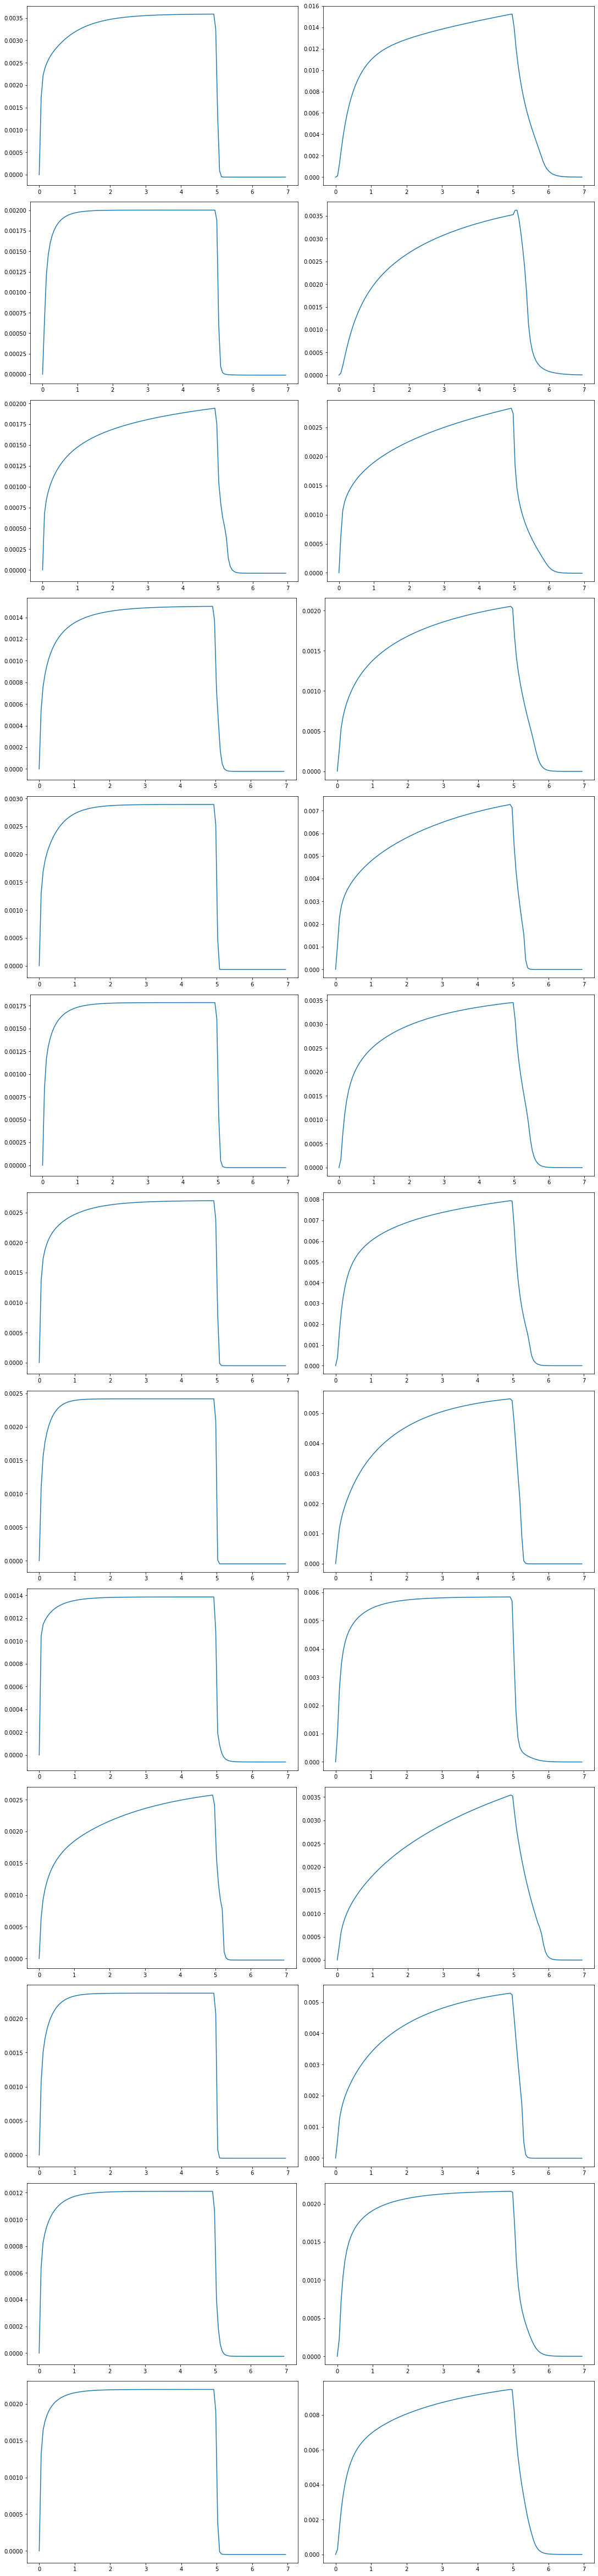

In [61]:
num = 13
fig = plt.figure(constrained_layout=True, figsize=(15, 5*num))
samples = fig.subfigures(nrows=num, ncols=1)

random =  np.random.choice(range(0, len(curves)), num)
x = np.linspace(0, 7, num=128, endpoint=False)
for i in range(num):
    curves = samples[i].subplots(nrows=1, ncols=2)
    
    for n, probe in enumerate(a[i]):
        curves[n].plot(x, probe)
plt.plot()  

# Stats

Text(0.5, 1.0, 'ME')

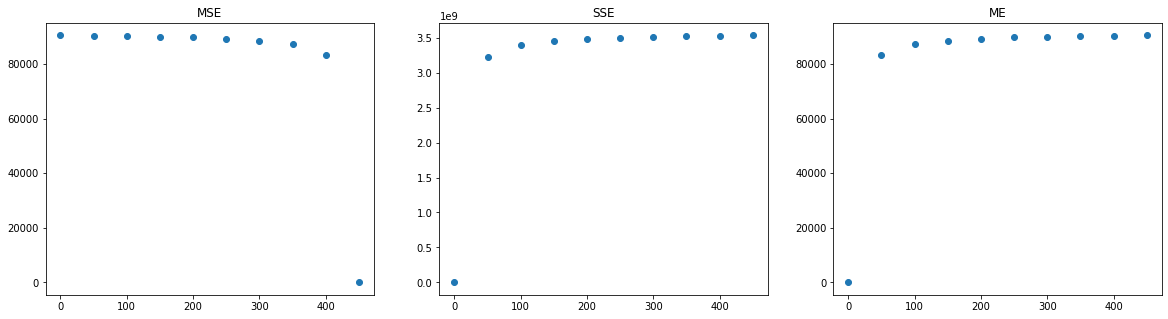

In [30]:
mse = [2.617318897435616e-11, 24710.833214317467, 26001.69611563166, 26447.173252396628, 26672.830389218187, 26809.16783071286, 26900.45455632038, 26965.85360834978, 27015.009344242335, 27053.304739832198]
sse = [3.4176950162714275e-06, 3226740601.1255746, 3395301478.7791824, 3453471883.2979517, 3482938192.2241106, 3500741135.3344855, 3512661355.964315, 3521201164.178314, 3527619920.171164, 3532620532.9272885]
me = [0.0001773903836016855, 83135.5859375, 87178.8046875, 88573.4375, 89279.8046875, 89706.5546875, 89992.28125, 90196.984375, 90350.8359375, 90470.6953125]

mse = np.flip(me)
x = range(1, 500, 50)

fix, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(x, mse)
ax[0].set_title("MSE")
ax[1].scatter(x, sse)
ax[1].set_title("SSE")
ax[2].scatter(x, me)
ax[2].set_title("ME")


In [73]:
from sklearn.metrics import mean_squared_error
import random
import pickle
import os
from tqdm import tqdm
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from numba import jit, cuda

SAMPLE_FILE = "samples.pkl"
SIGNAL_FOLDER = "D:\SamplingResults"

#jit(target_backend='cuda')  
def check():
    me = []
    mse = []
    sse = []
    pts = list(range(50, 500, 50))

    f = open(f"{SAMPLE_FILE}", "rb")
    samples = pickle.load(f).astype(np.float32)
    f.close()
    print(pts)
    for steps in pts:
        x_interped = []
        x_origin = []

        exps = os.listdir(f"{SIGNAL_FOLDER}/")
        fail = False
        print(len(x_origin))
        for i, run in enumerate(exps):
            if i > 50:
                break
            inp = []
            fail = False
            files = os.listdir(f"{SIGNAL_FOLDER}/{run}/")

            if files != ['Disp1.csv', 'Disp2.csv']:
                continue
            
            processed = 0
            for file in files:
                a = pd.read_csv(f"{SIGNAL_FOLDER}/{run}/{file}")
                a.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)

                # Interpolate curve for consistent x values
                xNew = np.linspace(0, 7, num=steps, endpoint=False)
                interped = interp1d(a['x'], a['y'], kind='cubic', fill_value="extrapolate")(xNew)
                if a['x'].max() != 7.0:
                    fail = True
                    
                    break

                # Find closest value in original to interpreted
                orig = np.array(a['y'].values)
                closest = []
                for y in interped:
                    diff = []
                    for y_2 in orig:
                        # Get difference
                        diff.append(abs(y_2 - y))

                    # Find location of smallest difference
                    idx = np.array(diff).argmin()
                    # Use as representative point
                    closest.append(orig[idx])

                x_interped.append(interped.astype(np.float32))
                #print(len(closest))
                x_origin.append(closest)
                processed += 1

            if fail and processed == 1:
                del x_interped[-1]
                del x_origin[-1]
        
        x_origin = np.array(x_origin).flatten()
        x_interped = np.array(x_interped).flatten()
        mse.append(mean_squared_error(x_origin, x_interped))
        print(mse[-1])
        sse.append(mse[-1]*len(x_origin))
        me.append(np.max(np.absolute(np.array(x_origin) - np.array(x_interped))))
        x_interped = []
        x_origin = []
   
    return mse, sse, me


In [74]:
print(mse)

[4.55012296777276e-11, 4.15145915428716e-11, 3.4392021951538436e-11, 2.5546538384639424e-11, 3.143022094104757e-11, 2.9157811089309336e-11, 4.7154617896647075e-11, 2.4879336373032155e-11, 2.7008297450650064e-11]


In [75]:
mse, sse, me = check()

[50, 100, 150, 200, 250, 300, 350, 400, 450]
0
4.55012296777276e-11
0
4.15145915428716e-11
0
3.4392021951538436e-11
0
2.5546538384639424e-11
0
3.143022094104757e-11
0
2.9157811089309336e-11
0
4.7154617896647075e-11
0
2.4879336373032155e-11
0
2.7008297450650064e-11


9
9


Text(0.5, 1.0, 'ME')

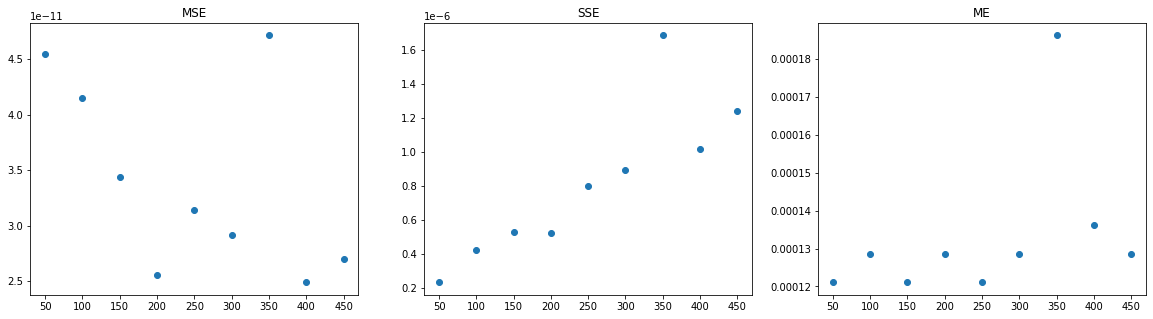

In [76]:
x = range(50, 500, 50)
print(len(mse))
print(len(x))

fix, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(x, mse)
ax[0].set_title("MSE")
ax[1].scatter(x, sse)
ax[1].set_title("SSE")
ax[2].scatter(x, me)
ax[2].set_title("ME")

# Check parameters

In [151]:
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

scaler = MinMaxScaler()

with open("samples.pkl", "rb") as f:
    samples = pickle.load(f)

with open("newSamples.pkl", "rb") as f:
    newSamples = pickle.load(f)
    
# Get only uniques
allSamples = np.unique(np.concatenate([newSamples, samples]), axis=0)

with open("filtered.pkl", "rb") as f:
    filtered = pickle.load(f)

feasibleSamples = allSamples[filtered]

# Normalise
scaler.fit_transform(allSamples)
allSamples = scaler.transform(allSamples)

allSamples = [tuple(t) for t in allSamples]
feasibleSamples = [tuple(t) for t in feasibleSamples]
nonFeasibleSamples = list(set(allSamples)-set(feasibleSamples))

data = {}
s = np.concatenate([feasibleSamples, nonFeasibleSamples], axis=0)
for i in range(6):
    data[f'y{i}'] = s[:, i]
data['Feasible'] = np.concatenate([np.repeat("green", len(feasibleSamples)), np.repeat("black", len(nonFeasibleSamples))], axis=0)

df = pd.DataFrame(
    data)

fig = px.parallel_coordinates(pd.concat([df[:-2], df[:-2]]), color="Feasible",
                              color_continuous_scale=px.colors.diverging.Tealrose,
                             #color_continuous_midpoint=0.5,
                              )
fig.show()

"""# Plot parrallel coordinates
x = list(range(0, 6))
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1, 6, sharey=False, figsize=(30, 7))
ax = (ax1,ax2,ax3,ax4,ax5,ax6)


for p in list(nonFeasibleSamples)[:5]:
    for i in range(5):
        ax[i].plot(x,p,'r-.')
        ax[i].set_xlim([ x[i],x[i+1]])

for p in list(feasibleSamples)[:5]:
    for i in range(3):
        ax[i].plot(x,p,'g-.')
        ax[i].set_xlim([ x[i],x[i+1]])
        
plt.subplots_adjust(wspace=0)
        """

KeyboardInterrupt: 

In [73]:
np.concatenate([np.repeat(True, len(feasibleSamples)), np.repeat(False, len(nonFeasibleSamples))], axis=0).reshape(-1)

(133308,)

In [142]:
feasibleSamples == nonFeasibleSamples

False